# Load packages

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression


import lightgbm as lgb
import gc # memory 
from datetime import datetime # train time checking

pd.set_option('display.max_columns', 100)

# Parameters

In [45]:
#VALIDATION
VALIDATE = False  #validation using train_test_split
VALID_SIZE = 0.90 # simple validation using train_test_split

#CROSS-VALIDATION
VALIDATE_KFOLDS = True #cross-validation using KFolds
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

SAMPLE = False    #True: use train.sample (100,000 rows) False: use full training set (train)
RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50  #lgb early stop 
OPT_ROUNDS = 650  #To be adjusted based on best validation rounds
skiprows = range(1,109903891) #
nrows = 75000000
#USE SAMPLE FROM FULL TRAIN SET
SAMPLE_SIZE = 0.2 # use a subsample of the train set
output_filename = 'submission.csv'

#path = '../input/'
path = '../input/talking_data/'


# Read the data

In [84]:

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

train_cols = ['ip','app','device','os', 'channel', 'click_time', 'is_attributed']

if SAMPLE:
    trainset = pd.read_csv(path+"train_sample.csv", dtype=dtypes, usecols=train_cols)    
else:
    trainset = pd.read_csv(path+"train.csv", skiprows=skiprows, nrows=nrows,dtype=dtypes, usecols=train_cols)
    trainset = trainset.sample(frac=SAMPLE_SIZE)

#trainset = pd.read_csv('../input/talking_data/train_sample.csv')
testset = pd.read_csv(path+"test.csv")

# Few quick observations

Let's check the train and test set structure


In [64]:
trainset.head()


,ip,app,device,os,channel,click_time,is_attributed,year,month,day,hour
24192086,137052,15,1,19,3,2017-11-09 00:39:37,0,2017,11,9,0
67865228,43827,9,1,13,466,2017-11-09 13:48:41,0,2017,11,9,13
37055112,90652,6,1,16,459,2017-11-09 04:34:10,0,2017,11,9,4
37332696,110707,6,1,19,125,2017-11-09 04:38:04,0,2017,11,9,4
11111564,96063,15,1,19,245,2017-11-08 15:38:18,0,2017,11,8,15


In [65]:
testset.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


The trainset columns are:
* **ip**: ip address of click (numeric);
* **app**: app id for marketing (category);
* **device**: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.) (category);
* **os**: os version id of user mobile phone (category);
* **channel**: channel id of mobile ad publisher (category);
* **click_time**: timestamp of click (UTC) (time);
* **attributed_time**: if user download the app for after clicking an ad, this is the time of the app download (time);
* **is_attributed**: the target that is to be predicted, indicating the app was downloaded (binary);

The testset differs with three columns:
* **click_id** reference for making predictions (additional column) (numeric);
* **attributed_time**: missing column;
* **is_attributed**: missing column (target column) (binary).

Let's see what is the dimmension of the train and test set.



In [85]:
print("Train dataset (rows, cols):",trainset.shape, "\nTest dataset (rows, cols):",testset.shape)

Train dataset (rows, cols): (15000000, 7) 
Test dataset (rows, cols): (18790469, 7)


# Data analysis and statistics

## Target (is_attributed) variable 

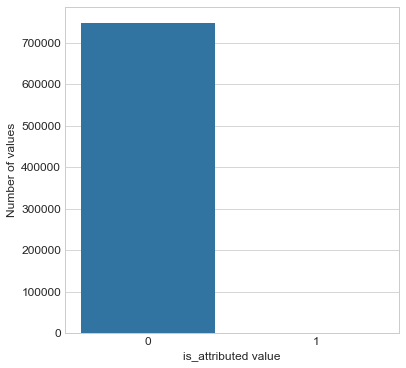

In [67]:
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
x = trainset['is_attributed'].value_counts().index.values
y = trainset["is_attributed"].value_counts().values
# Bar plot
# Order the bars descending on target mean
sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('is_attributed value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

Only a very small part of the **is_attributed** data have 1 value (227 out of 100,000 values). This means that the training dataset is highly imbalanced. Usually is used either undersample the records with **is_attributed** = 0 or oversample records with **is_attributed** = 1; because is a large dataset, it is a good option to do undersampling of records with **is_attributed** = 0.

In [68]:
trainset.describe()

,ip,app,device,os,channel,is_attributed,year,month,day,hour
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.0,750000.0,750000.000000,750000.000000
mean,94607.344523,11.561740,12.982157,21.209356,266.206113,0.002324,2017.0,11.0,8.707115,10.038019
std,79287.593605,13.241947,209.928413,49.193851,130.988233,0.048152,0.0,0.0,0.455087,5.870943
min,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.0,11.0,8.000000,0.000000
25%,40001.000000,3.000000,1.000000,13.000000,137.000000,0.000000,2017.0,11.0,8.000000,5.000000
50%,78801.000000,11.000000,1.000000,18.000000,245.000000,0.000000,2017.0,11.0,9.000000,11.000000
75%,115981.000000,15.000000,1.000000,19.000000,379.000000,0.000000,2017.0,11.0,9.000000,14.000000
max,364764.000000,766.000000,4208.000000,866.000000,498.000000,1.000000,2017.0,11.0,9.000000,23.000000


We can observe that, while ip is a number with a wide range of values, **app**, **device**, **os** and **channel** are categorical values with a smaller range of variation. Let's separate between values with **is_attributed** with value `1` and value `0`.

In [69]:
t1 = trainset.loc[trainset['is_attributed'] != 0.]
t0 = trainset.loc[trainset['is_attributed'] == 0.]

t0.describe()

,ip,app,device,os,channel,is_attributed,year,month,day,hour
count,748257.000000,748257.000000,748257.000000,748257.000000,748257.000000,748257.0,748257.0,748257.0,748257.000000,748257.00000
mean,94343.483886,11.523314,12.903142,21.195959,266.337564,0.0,2017.0,11.0,8.706987,10.03929
std,78961.700789,13.144748,209.656569,49.130695,131.001506,0.0,0.0,0.0,0.455145,5.87146
min,6.000000,0.000000,0.000000,0.000000,0.000000,0.0,2017.0,11.0,8.000000,0.00000
25%,39868.000000,3.000000,1.000000,13.000000,137.000000,0.0,2017.0,11.0,8.000000,5.00000
50%,78672.000000,11.000000,1.000000,18.000000,245.000000,0.0,2017.0,11.0,9.000000,11.00000
75%,115837.000000,15.000000,1.000000,19.000000,379.000000,0.0,2017.0,11.0,9.000000,14.00000
max,364764.000000,766.000000,4208.000000,866.000000,498.000000,0.0,2017.0,11.0,9.000000,23.00000


In [70]:
t1.describe()

,ip,app,device,os,channel,is_attributed,year,month,day,hour
count,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.0,1743.0,1743.0,1743.000000,1743.000000
mean,207880.763052,28.057946,46.903041,26.960413,209.775100,1.0,2017.0,11.0,8.761905,9.492255
std,124796.965995,31.688959,303.207937,71.102674,111.715862,0.0,0.0,0.0,0.426040,5.619470
min,107.000000,0.000000,0.000000,0.000000,3.000000,1.0,2017.0,11.0,8.000000,0.000000
25%,81073.000000,11.000000,0.000000,13.000000,113.000000,1.0,2017.0,11.0,9.000000,5.000000
50%,251392.000000,19.000000,1.000000,19.000000,213.000000,1.0,2017.0,11.0,9.000000,10.000000
75%,321303.500000,35.000000,1.000000,27.000000,274.000000,1.0,2017.0,11.0,9.000000,13.000000
max,364633.000000,481.000000,4198.000000,866.000000,489.000000,1.0,2017.0,11.0,9.000000,23.000000


We can observe that in the two sets, **ip** and **os** and **channel** have values in the same ranges for both **is_attributed** values (0 and 1). Maximum values for **app** is almost double and maximum value for **device** is four times larger for **is_attributed** = 0.

Let's visualize the distribution of values of **app**, **device**, **os** and **channel**, grouped on **is_attributed**.

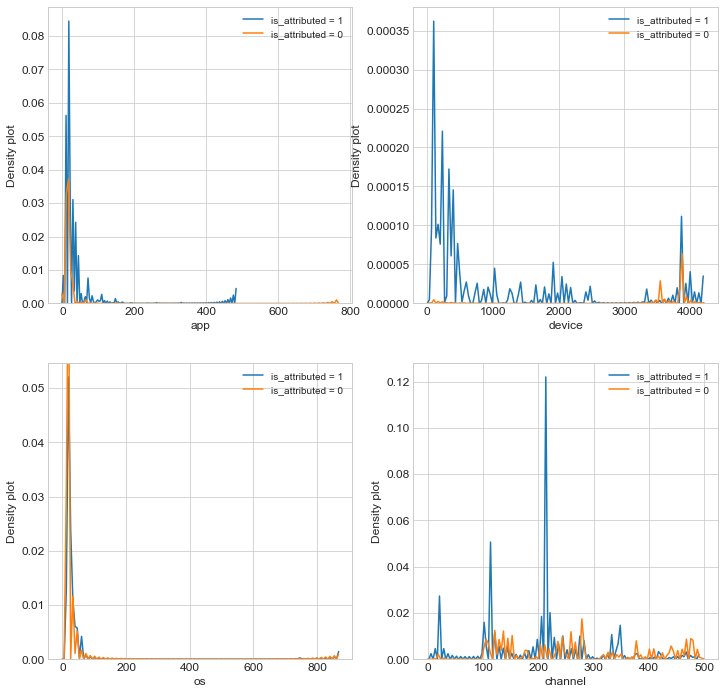

In [71]:
var = ['app','device','os','channel']

i = 0
t1 = trainset.loc[trainset['is_attributed'] != 0]
t0 = trainset.loc[trainset['is_attributed'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(12,12))

for feature in var:
    i += 1
    plt.subplot(2,2,i)
    sns.kdeplot(t1[feature], bw=0.5,label="is_attributed = 1")
    sns.kdeplot(t0[feature], bw=0.5,label="is_attributed = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

# Data engineering

## Extract date and time data

In [72]:
trainset['year'] = pd.to_datetime(trainset.click_time).dt.year
trainset['month'] = pd.to_datetime(trainset.click_time).dt.month
trainset['day'] = pd.to_datetime(trainset.click_time).dt.day
trainset['hour'] = pd.to_datetime(trainset.click_time).dt.hour
trainset['min'] = pd.to_datetime(trainset.click_time).dt.minute
trainset['sec'] = pd.to_datetime(trainset.click_time).dt.second
trainset.head()

,ip,app,device,os,channel,click_time,is_attributed,year,month,day,hour,min,sec
24192086,137052,15,1,19,3,2017-11-09 00:39:37,0,2017,11,9,0,39,37
67865228,43827,9,1,13,466,2017-11-09 13:48:41,0,2017,11,9,13,48,41
37055112,90652,6,1,16,459,2017-11-09 04:34:10,0,2017,11,9,4,34,10
37332696,110707,6,1,19,125,2017-11-09 04:38:04,0,2017,11,9,4,38,4
11111564,96063,15,1,19,245,2017-11-08 15:38:18,0,2017,11,8,15,38,18


In [73]:
trainset.describe()

,ip,app,device,os,channel,is_attributed,year,month,day,hour,min,sec
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.0,750000.0,750000.000000,750000.000000,750000.000000,750000.000000
mean,94607.344523,11.561740,12.982157,21.209356,266.206113,0.002324,2017.0,11.0,8.707115,10.038019,29.583596,29.539085
std,79287.593605,13.241947,209.928413,49.193851,130.988233,0.048152,0.0,0.0,0.455087,5.870943,17.419966,17.252705
min,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.0,11.0,8.000000,0.000000,0.000000,0.000000
25%,40001.000000,3.000000,1.000000,13.000000,137.000000,0.000000,2017.0,11.0,8.000000,5.000000,14.000000,15.000000
50%,78801.000000,11.000000,1.000000,18.000000,245.000000,0.000000,2017.0,11.0,9.000000,11.000000,30.000000,30.000000
75%,115981.000000,15.000000,1.000000,19.000000,379.000000,0.000000,2017.0,11.0,9.000000,14.000000,45.000000,44.000000
max,364764.000000,766.000000,4208.000000,866.000000,498.000000,1.000000,2017.0,11.0,9.000000,23.000000,59.000000,59.000000


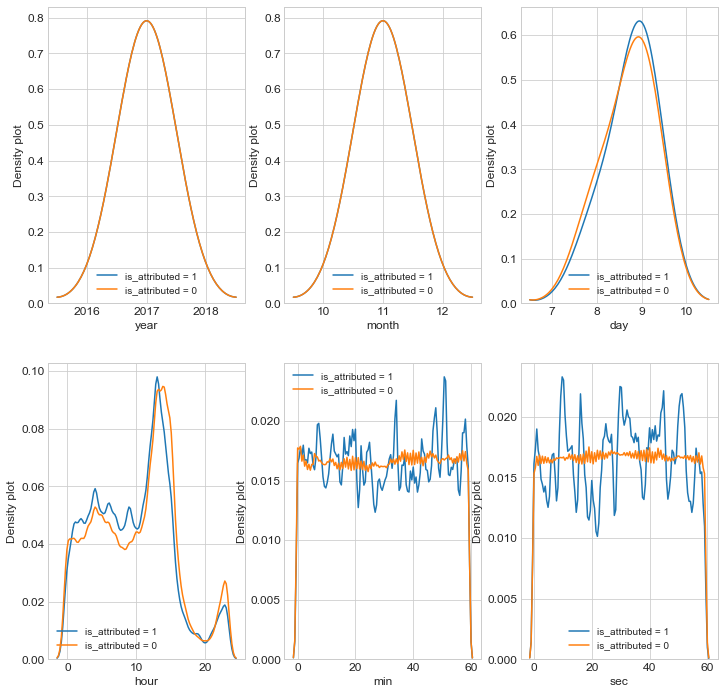

In [74]:
var = ['year','month','day','hour','min','sec']

i = 0
t1 = trainset.loc[trainset['is_attributed'] != 0]
t0 = trainset.loc[trainset['is_attributed'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,3,figsize=(12,12))

for feature in var:
    i += 1
    plt.subplot(2,3,i)
    sns.kdeplot(t1[feature], bw=0.5,label="is_attributed = 1")
    sns.kdeplot(t0[feature], bw=0.5,label="is_attributed = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

One can observe that the distribution for **true** (**is_attributed = 1**) clicks is more diverse (hour, min, sec) compared with **false** (**is_attributed = 0**). This might be explained in two ways: one explanation can be that due to the reduced number of **true** cases, the distribution is less uniform. Another explanation might be (to be verified with larger number of cases) that due to programatic nature of *artificial* (**false**) clicks, their distribution is more uniform. One observation, related to the density plot for hours: for both **true** and **false** there is a certain hourly profile, with a plateau between 1 and 16, a saddle between 16 and 20 and a peak between 21 and 22. The plateau for the artificial (**false**) clicks shows an additional pattern, with oscilant profile.

Let's represent the hour distribution with an alternative method, using barplots to show percent from all data of the **true** data.

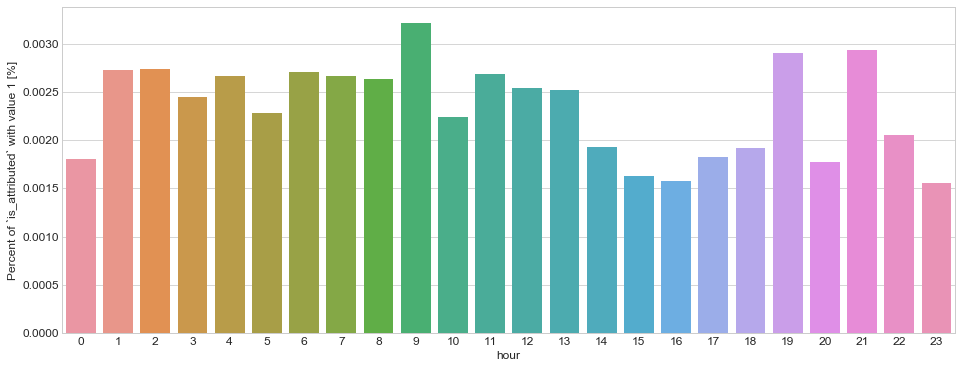

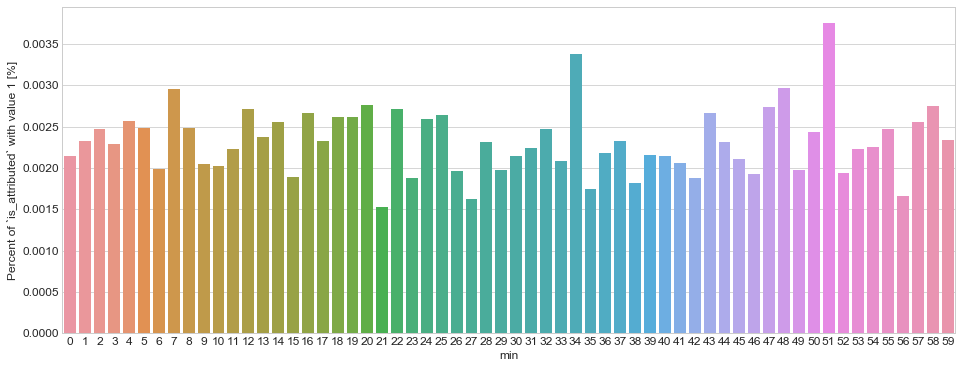

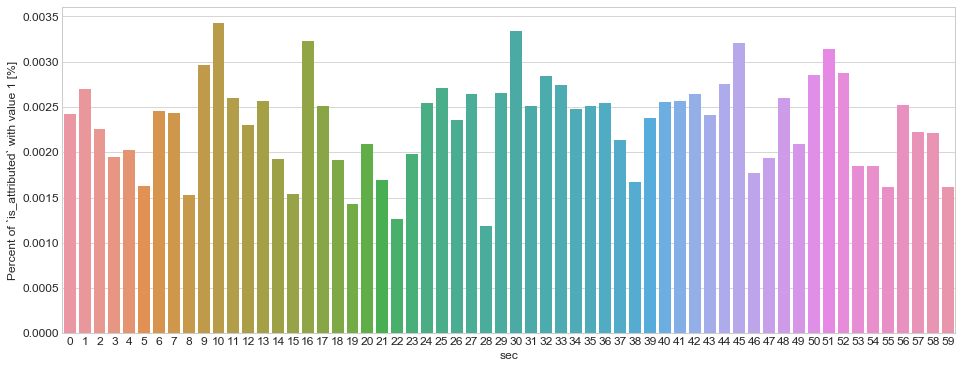

In [75]:
var = ['hour','min','sec']

for feature in var:
    fig, ax = plt.subplots(figsize=(16,6))
    # Calculate the percentage of target=1 per category value
    cat_perc = trainset[[feature, 'is_attributed']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='is_attributed', ascending=False, inplace=True)
    # Bar plot
    #sns.barplot(ax=ax,x=feature, y='is_attributed', data=cat_perc, order=cat_perc[feature]) #for ordered bars
    sns.barplot(ax=ax,x=feature, y='is_attributed', data=cat_perc)
    plt.ylabel('Percent of `is_attributed` with value 1 [%]', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

# Data unbalance between train and test data

Let's compare the distribution of the features in the train and test datasets.


Let's start with the data about application, devide, operating system and channel.

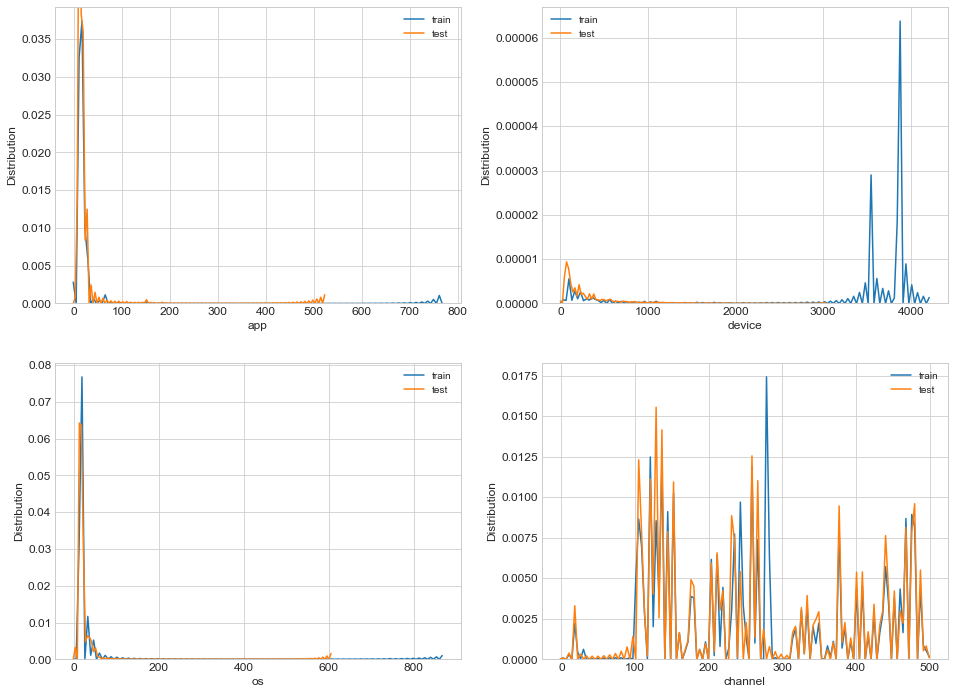

In [76]:
var = ['app','device','os','channel']

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(2,2,figsize=(16,12))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(2,2,i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

Let's continue with the data on time. First we will have to do the date and time extraction operation on testset data.

In [77]:
testset['year'] = pd.to_datetime(testset.click_time).dt.year
testset['month'] = pd.to_datetime(testset.click_time).dt.month
testset['day'] = pd.to_datetime(testset.click_time).dt.day
testset['hour'] = pd.to_datetime(testset.click_time).dt.hour
testset['min'] = pd.to_datetime(testset.click_time).dt.minute
testset['sec'] = pd.to_datetime(testset.click_time).dt.second
testset.head()

,click_id,ip,app,device,os,channel,click_time,year,month,day,hour,min,sec
0,0,5744,9,1,3,107,2017-11-10 04:00:00,2017,11,10,4,0,0
1,1,119901,9,1,3,466,2017-11-10 04:00:00,2017,11,10,4,0,0
2,2,72287,21,1,19,128,2017-11-10 04:00:00,2017,11,10,4,0,0
3,3,78477,15,1,13,111,2017-11-10 04:00:00,2017,11,10,4,0,0
4,4,123080,12,1,13,328,2017-11-10 04:00:00,2017,11,10,4,0,0


In [78]:
testset.describe()

,click_id,ip,app,device,os,channel,year,month,day,hour,min,sec
count,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07,18790469.0,18790469.0,18790469.0,1.879047e+07,1.879047e+07,1.879047e+07
mean,9.395234e+06,6.306921e+04,1.221480e+01,1.730513e+00,1.873312e+01,2.648059e+02,2017.0,11.0,10.0,9.219946e+00,2.932030e+01,2.952520e+01
std,5.424341e+06,3.688597e+04,1.164924e+01,2.597038e+01,1.135059e+01,1.355254e+02,0.0,0.0,0.0,3.751926e+00,1.731594e+01,1.728553e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2017.0,11.0,10.0,4.000000e+00,0.000000e+00,0.000000e+00
25%,4.697617e+06,3.155800e+04,3.000000e+00,1.000000e+00,1.300000e+01,1.350000e+02,2017.0,11.0,10.0,5.000000e+00,1.400000e+01,1.500000e+01
50%,9.395234e+06,6.393600e+04,1.200000e+01,1.000000e+00,1.800000e+01,2.360000e+02,2017.0,11.0,10.0,1.000000e+01,2.900000e+01,3.000000e+01
75%,1.409285e+07,9.531600e+04,1.800000e+01,1.000000e+00,1.900000e+01,4.010000e+02,2017.0,11.0,10.0,1.300000e+01,4.400000e+01,4.400000e+01
max,1.879047e+07,1.264130e+05,5.210000e+02,3.031000e+03,6.040000e+02,4.980000e+02,2017.0,11.0,10.0,1.500000e+01,5.900000e+01,5.900000e+01


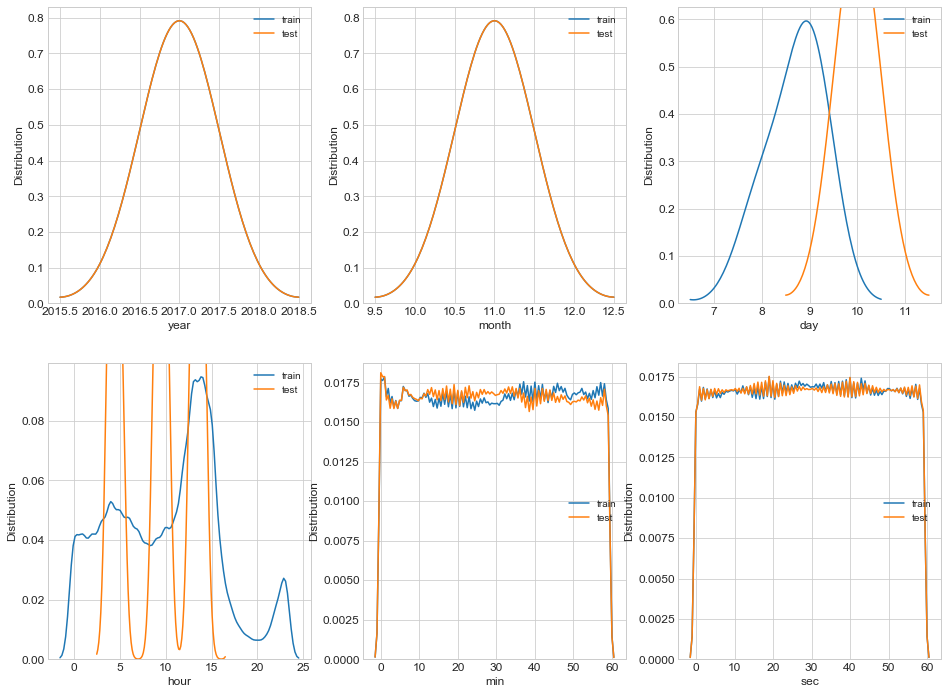

In [79]:
var = ['year','month','day','hour','min','sec']

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(2,3,figsize=(16,12))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(2,3,i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

We can see that the day for the train data is for 6-9 November 2017, the test data is only from 10 November 2017. As well, the hours distribution are very different between train and test data.


# Model

## Prepare the model

In [86]:
start = datetime.now()

len_train = len(trainset)
gc.collect()

most_freq_hours_in_test_data = [4, 5, 9, 10, 13, 14]
least_freq_hours_in_test_data = [6, 11, 15]

def prep_data( df ):
    
    df['hour'] = pd.to_datetime(df.click_time).dt.hour.astype('uint8')
    df['day'] = pd.to_datetime(df.click_time).dt.day.astype('uint8')
    df.drop(['click_time'], axis=1, inplace=True)
    gc.collect()
    
    df['in_test_hh'] = (   3 
                         - 2*df['hour'].isin(  most_freq_hours_in_test_data ) 
                         - 1*df['hour'].isin( least_freq_hours_in_test_data ) ).astype('uint8')
    gp = df[['ip', 'day', 'in_test_hh', 'channel']].groupby(by=['ip', 'day', 'in_test_hh'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'nip_day_test_hh'})
    df = df.merge(gp, on=['ip','day','in_test_hh'], how='left')
    df.drop(['in_test_hh'], axis=1, inplace=True)
    df['nip_day_test_hh'] = df['nip_day_test_hh'].astype('uint32')
    del gp
    gc.collect()

    gp = df[['ip', 'day', 'hour', 'channel']].groupby(by=['ip', 'day', 'hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'nip_day_hh'})
    df = df.merge(gp, on=['ip','day','hour'], how='left')
    df['nip_day_hh'] = df['nip_day_hh'].astype('uint16')
    del gp
    gc.collect()
    
    gp = df[['ip', 'os', 'hour', 'channel']].groupby(by=['ip', 'os', 'hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'nip_hh_os'})
    df = df.merge(gp, on=['ip','os','hour'], how='left')
    df['nip_hh_os'] = df['nip_hh_os'].astype('uint16')
    del gp
    gc.collect()

    gp = df[['ip', 'app', 'hour', 'channel']].groupby(by=['ip', 'app',  'hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'nip_hh_app'})
    df = df.merge(gp, on=['ip','app','hour'], how='left')
    df['nip_hh_app'] = df['nip_hh_app'].astype('uint16')
    del gp
    gc.collect()

    gp = df[['ip', 'device', 'hour', 'channel']].groupby(by=['ip', 'device', 'hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'nip_hh_dev'})
    df = df.merge(gp, on=['ip','device','hour'], how='left')
    df['nip_hh_dev'] = df['nip_hh_dev'].astype('uint32')
    del gp
    gc.collect()

    df.drop( ['ip','day'], axis=1, inplace=True )
    gc.collect()
    return df

In [87]:
trainset = prep_data(trainset)
gc.collect()

params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.1,
          'num_leaves': 9,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 5,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':99.7, # because training data is extremely unbalanced 
         }

target = 'is_attributed'
predictors = ['app','device','os', 'channel', 'hour', 'nip_day_test_hh', 'nip_day_hh', 'nip_hh_os', 'nip_hh_app', 'nip_hh_dev']
categorical = ['app', 'device', 'os', 'channel', 'hour']


## Train the model

In [89]:
if VALIDATE:

    train_df, val_df = train_test_split(trainset, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )
    
    dtrain = lgb.Dataset(train_df[predictors].values, 
                         label=train_df[target].values,
                         feature_name=predictors,
                         categorical_feature=categorical)
    del train_df
    gc.collect()

    dvalid = lgb.Dataset(val_df[predictors].values,
                         label=val_df[target].values,
                         feature_name=predictors,
                         categorical_feature=categorical)
    del val_df
    gc.collect()

    evals_results = {}

    model = lgb.train(params, 
                      dtrain, 
                      valid_sets=[dtrain, dvalid], 
                      valid_names=['train','valid'], 
                      evals_result=evals_results, 
                      num_boost_round=MAX_ROUNDS,
                      early_stopping_rounds=EARLY_STOP,
                      verbose_eval=50, 
                      feval=None)

    del dvalid
    
elif VALIDATE_KFOLDS:
    kf = KFold(n_splits = NUMBER_KFOLDS, random_state = RANDOM_STATE, shuffle = True)
    for train_index, test_index in kf.split(trainset):
        train_X, valid_X = trainset.iloc[train_index], trainset.iloc[test_index]

        dtrain = lgb.Dataset(train_X[predictors].values, label=train_X[target].values,
                         feature_name=predictors, categorical_feature=categorical)
   
        dvalid = lgb.Dataset(valid_X[predictors].values, label=valid_X[target].values,
                         feature_name=predictors, categorical_feature=categorical)
    
        evals_results = {}
        model =  lgb.train(params, 
                      dtrain, 
                      valid_sets=[dtrain, dvalid], 
                      valid_names=['train','valid'], 
                      evals_result=evals_results, 
                      num_boost_round=MAX_ROUNDS,
                      early_stopping_rounds=EARLY_STOP,
                      verbose_eval=50, 
                      feval=None)
    
else:

    gc.collect()
    dtrain = lgb.Dataset(train_df[predictors].values, label=train_df[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical
                          )
    del train_df
    gc.collect()

    evals_results = {}

    model = lgb.train(params, 
                      dtrain, 
                      valid_sets=[dtrain], 
                      valid_names=['train'], 
                      evals_result=evals_results, 
                      num_boost_round=OPT_ROUNDS,
                      verbose_eval=50,
                      feval=None)
    
del dtrain
gc.collect()

C:\Program_Files\Anaconda3\lib\site-packages\lightgbm\basic.py:1005: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds.
[50]	train's auc: 0.969874	valid's auc: 0.965354
[100]	train's auc: 0.974924	valid's auc: 0.968389
[150]	train's auc: 0.977519	valid's auc: 0.969184
[200]	train's auc: 0.979205	valid's auc: 0.969391
[250]	train's auc: 0.980506	valid's auc: 0.969456
[300]	train's auc: 0.981648	valid's auc: 0.969463
[350]	train's auc: 0.982449	valid's auc: 0.969482
Early stopping, best iteration is:
[323]	train's auc: 0.982015	valid's auc: 0.969551
Training until validation scores don't improve for 50 rounds.


KeyboardInterrupt: 

# Prediction and submission

In [19]:
test_cols = ['ip','app','device','os', 'channel', 'click_time', 'click_id']

test_df = prep_data(testset)
gc.collect()

sub = pd.DataFrame()
sub['click_id'] = test_df['click_id']
sub['is_attributed'] = model.predict(test_df[predictors])
sub.to_csv(output_filename, index=False, float_format='%.9f')
